## Fine-Tuning with Sentence Transformers
In this notebook, we will learn about `sentence_transformers` library and then we will fine-tune a `bert-base-uncased` model with 2 different type of datasets:
- Triplets
- Sentence pairs with labels (SNLI)

Let's first install the required dependencies and modules

We will use `all-MiniLM-L6-v2` to play around with sentence transformer features 

In [1]:
import os
try:
    print(file_path)
except:
    file_path = os.path.abspath('')
    os.chdir(os.path.dirname(file_path))
    print(file_path)

/home/mrzaizai2k/code_Bao/LLM-with-RAG/notebook


In [2]:
# model
from sentence_transformers import SentenceTransformer, util, InputExample
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import torch

import pandas as pd
from src.utils import *

/home/mrzaizai2k/code_Bao/LLM-with-RAG/venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
device = take_device()
model_type = "sentence-transformers/distiluse-base-multilingual-cased-v2"
output_path = "model/distilroberta-triplets_2"

Selected device: cuda


In [4]:
model = SentenceTransformer(model_type)
model.to(device)

/home/mrzaizai2k/code_Bao/LLM-with-RAG/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Dense({'in_features': 768, 'out_features': 512, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)

### Cosine Similarity between Sentences

You can use cosine similarity to find out the similarity between 2 sentences. Sentence transformers allow us to find the cosine similarity score between 2 sentences so let’s see it in action!

First, we will import the required modules and convert our sentences into embeddings using the same model we used before

## Training a model using a triplets dataset
Now we have enough knowledge about sentence transformers, so let's fine-tune a base model from scratch
Please [read the blog](https://www.ionio.ai/blog/fine-tuning-embedding-models-using-sentence-transformers-code-included) to read about the fine-tuning process in more detail.

Let’s first pull our base model and apply pooling on it so that we can get fixed 768 sized embedding array in output

In [5]:
# Training a bert model using sentence transformer
from sentence_transformers import SentenceTransformer, models
import torch

word_embedding_model = models.Transformer(model_type, max_seq_length=256)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

Now let’s pull our dataset, we are going to use `embedding-data/QQP_triplets` but you can use any other triplet dataset too if you want

In [6]:
# Using QQP Triples dataset for training
from datasets import load_dataset

dataset_id = "5CD-AI/Vietnamese-395k-meta-math-MetaMathQA-gg-translated"
dataset = load_dataset(dataset_id)

Generating train split:   0%|          | 0/395000 [00:00<?, ? examples/s]

Let’s take a look at how each data looks like in dataset

In [7]:
dataset['train']['set'][0]

KeyError: "Column set not in the dataset. Current columns in the dataset: ['response_en', 'original_question_en', 'type', 'query_en', 'original_question_vi', 'query_vi', 'response_vi']"

As we can see, each example have a query, a positive sentence which is similar to that query and a list of negative sentences which are not similar to query.

We can’t directly pass this dataset examples into our model because first we have to convert them to a specific format that sentence transformers and model can understand. Every training example must be in “InputExample” format in sentence transformers so we will convert our dataset data into this format.

We will also take only first sentence from both `pos` and `neg` arrays to make it easy but in production scenario, you might need to pass the full array for better performance and accuracy

In [ ]:

train_examples = []
train_data = dataset['train']['set']
# For agility we only 1/2 of our available data
# n_examples = dataset['train'].num_rows // 4
for i in range(0,100):
  example = train_data[i]
  train_examples.append(InputExample(texts=[example['query'],example['pos'][0],example['neg'][0]]))

In [9]:
# def load_data_from_csv(file_path):
#     # Read the CSV file
#     df = pd.read_csv(file_path)
    
#     # Initialize an empty list to hold the examples
#     train_examples = []

#     # Iterate over the rows of the DataFrame
#     for _, row in df.iterrows():
#         # Create an InputExample object and append it to the list
#         example = InputExample(texts=[row['anchor'], row['positive'], row['negative']])
#         train_examples.append(example)

#     return train_examples

# file_path = 'data/triplet_dataset.csv'
# train_examples = load_data_from_csv(file_path)

Now let’s create our dataloader

In [10]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=64)

Now let’s define our loss function. We can use “losses” class from sentence transformers which allows us to get different loss functions that we discussed above.

We just have to attach the model to triplet loss function

In [11]:
from sentence_transformers import losses
train_loss = losses.TripletLoss(model)

And now we are ready, let’s combine everything we prepared and fine-tune the model using `model.fit` method which takes dataloader and loss function as a train objectives.

In [12]:
model.fit(train_objectives=[(train_dataloader, train_loss)], 
          epochs=4,
          output_path = output_path)

Step,Training Loss


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Now let’s push this fine-tuned model on huggingface so that we can share it with other people and they can also see what we cooked!

First login with huggingface using your access token

In [13]:
# from huggingface_hub import notebook_login

# notebook_login()

After that. call `save_to_hub` method to push your model on huggingface

In [14]:
# model.push_to_hub(
#     "chibao24/distilroberta-base-sentence-transformer-triplets", # Give a name to your model
#     )

In [15]:
from sentence_transformers import SentenceTransformer, models
# Evaluation
sentences = [
    "The complexity of karger min cut is O(n)",
    "Karger min cut the fastest randomized algorithms",
    "We need the fastest randomized algorithms",
    "Karger is the fastest runner in the 20th century",
    "Top ten fastest algorithms has FFT and Karger",
    "Microservices is the fastest and decouple architecture",
    "Microkernel architecture was most used in 20th century because it's lightweght and compacteness",
    "Ông Karger đã làm việc tại đại học Yale về microkernel architecture",
    "We need at least 3 min cut to success at 8th step ",
    "Độ phức tạp của thuật toán Karger là rất thấp vì thế nó rất nhanh",
    "What is the runing time of Karger algorithm?",
    "Karger entered Trinity Colege, where he exceled in Microservices and in moral science",
    
]

Let’s first get the embeddings  of these sentences using “bert-base-uncased” model which is our base model

In [16]:
base_model = SentenceTransformer(model_type)
# Sentences are encoded by calling model.encode()
sentence_embeddings = base_model.encode(sentences)

/home/mrzaizai2k/code_Bao/LLM-with-RAG/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Now let’s reduce the embedding dimensions using TSNE

In [17]:

embeddings = np.array(sentence_embeddings)
tsne = TSNE(n_components=2, random_state=42,perplexity=5)
embeddings_2d = tsne.fit_transform(embeddings)

Now we have 2D embeddings, we will do clustering to classify all these embeddings into different classes so that it will be easy for us to visualize how these models are classifying different embeddings and the positions of embeddings in vector space

In [18]:
# Perform kmean clustering
num_clusters = 3
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(sentence_embeddings)
cluster_assignment = clustering_model.labels_
print(cluster_assignment)

[2 1 1 1 1 0 0 0 2 1 1 0]


/home/mrzaizai2k/code_Bao/LLM-with-RAG/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


If you print the `cluster_assignment` array then you will see the class labels for every sentence which shows the class of each sentence

Now let’s plot these embeddings in 2D vector space using metaplotlib

### Plotting the results of fine-tuned model using triplets

First pull the model from huggingface

Prepare the sentence embeddings

In [23]:
def plot_embedding(emb_model, sentences:list[str], title:str, num_clusters:int = 4, colors:list = ["orange","red","green","blue"]):

    sentence_embeddings = emb_model.encode(sentences)
    clustering_model = KMeans(n_clusters=num_clusters)
    clustering_model.fit(sentence_embeddings)
    cluster_assignment = clustering_model.labels_
    embeddings = np.array(sentence_embeddings)
    tsne = TSNE(n_components=2, random_state=42,perplexity=5)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Create a scatter plot
    plt.figure(figsize=(8, 6))  # Adjust figure size as needed
    for index,embedding in enumerate(embeddings_2d):
        plt.scatter(embedding[0],embedding[1],color=colors[cluster_assignment[index]])
    # plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])  # Use first two columns for x and y

    # Optional: Add labels and title
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

    # Optional: Add sentence labels (consider using for small datasets like yours)
    for i, sentence in enumerate(sentences):
        plt.annotate(sentence[:50], (embeddings_2d[i, 0], embeddings_2d[i, 1]))

    plt.grid(False)
    plt.show()

In [24]:
model = SentenceTransformer(output_path)
base_model = SentenceTransformer(model_type)

/home/mrzaizai2k/code_Bao/LLM-with-RAG/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


/home/mrzaizai2k/code_Bao/LLM-with-RAG/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


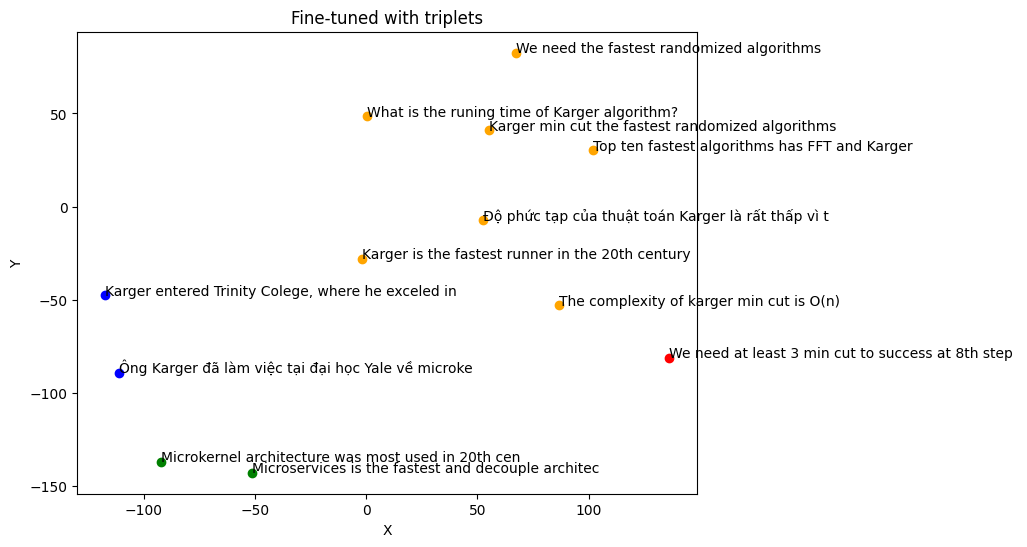

In [25]:
plot_embedding(model, sentences, title = "Fine-tuned with triplets")

/home/mrzaizai2k/code_Bao/LLM-with-RAG/venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


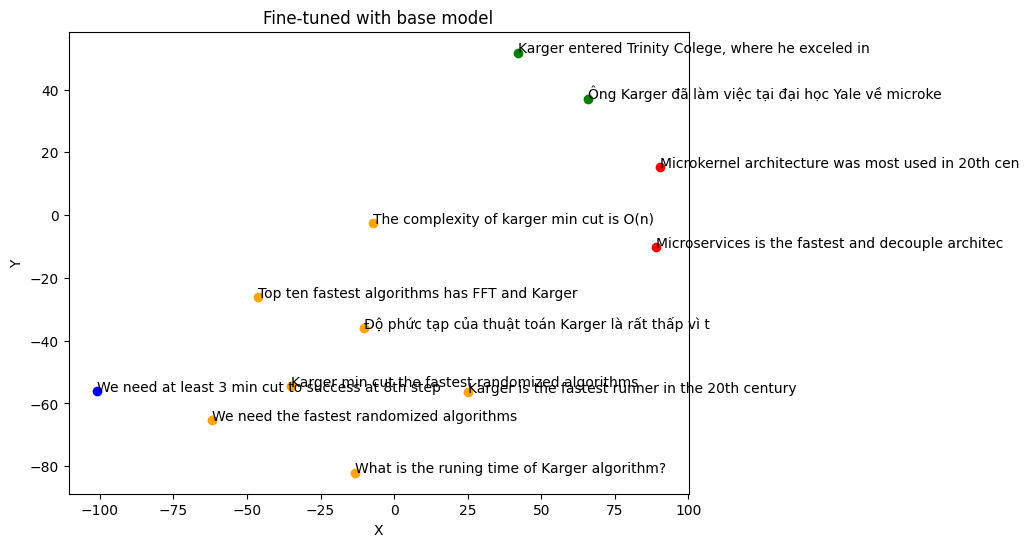

In [26]:
plot_embedding(base_model, sentences, title = "Fine-tuned with base model")